In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(end_date)

('2017-08-23',)


In [13]:
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(start_date)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
yearly_precipitation = session.query(Measurement.prcp, Measurement.date).\
            filter(Measurement.date <= '2017-08-23').\
            filter(Measurement.date >= '2016-08-23').all()

yearly_precipitation

[(0.0, '2016-08-23'),
 (0.08, '2016-08-24'),
 (0.08, '2016-08-25'),
 (0.0, '2016-08-26'),
 (0.0, '2016-08-27'),
 (0.01, '2016-08-28'),
 (0.0, '2016-08-29'),
 (0.0, '2016-08-30'),
 (0.13, '2016-08-31'),
 (0.0, '2016-09-01'),
 (0.0, '2016-09-02'),
 (0.0, '2016-09-03'),
 (0.03, '2016-09-04'),
 (None, '2016-09-05'),
 (None, '2016-09-06'),
 (0.05, '2016-09-07'),
 (0.0, '2016-09-08'),
 (0.03, '2016-09-09'),
 (0.0, '2016-09-10'),
 (0.05, '2016-09-11'),
 (0.0, '2016-09-12'),
 (0.02, '2016-09-13'),
 (1.32, '2016-09-14'),
 (0.42, '2016-09-15'),
 (0.06, '2016-09-16'),
 (0.05, '2016-09-17'),
 (0.0, '2016-09-18'),
 (0.0, '2016-09-19'),
 (0.0, '2016-09-20'),
 (0.0, '2016-09-21'),
 (0.02, '2016-09-22'),
 (0.0, '2016-09-23'),
 (0.0, '2016-09-24'),
 (0.0, '2016-09-25'),
 (0.06, '2016-09-26'),
 (0.02, '2016-09-27'),
 (0.0, '2016-09-28'),
 (0.0, '2016-09-29'),
 (0.0, '2016-09-30'),
 (0.0, '2016-10-01'),
 (0.0, '2016-10-02'),
 (0.0, '2016-10-03'),
 (0.0, '2016-10-04'),
 (0.0, '2016-10-05'),
 (0.0, '2016-1

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(yearly_precipitation, columns=['precipitation', 'date'])
precip_df.set_index('date', inplace=True)

In [16]:
precip_df.sort_index(ascending=True, inplace=True)
precip_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


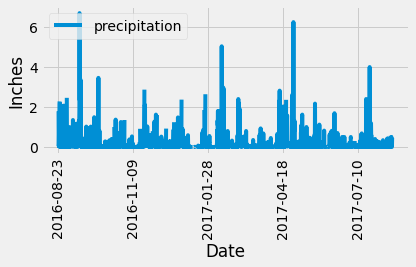

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(y='precipitation', rot=90)
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281').all()

highest_temp = session.query(func.max(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281').all()

average_temp = session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281').all()

print(f"The lowest temperature recorded was {lowest_temp}, the highest temperature recorded was {highest_temp}, and the average temperature recorded was {average_temp}")


The lowest temperature recorded was [(54.0,)], the highest temperature recorded was [(85.0,)], and the average temperature recorded was [(71.66378066378067,)]


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observations = session.query(Measurement.station, Measurement.tobs).\
                    filter(Measurement.date <= '2017-08-23').\
                    filter(Measurement.date >= '2016-08-23').\
                    filter(Measurement.station == 'USC00519281').all()
temp_observations

[('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 75.0),
 ('USC00519281', 73.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 73.0),
 ('USC00519281', 74.0),
 ('USC00519281', 80.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 76.0),
 ('USC00519281', 79.0),
 ('USC00519281', 75.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 76.0),
 ('USC00519281', 74.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 79.0),
 ('USC00519281', 79.0),
 ('USC00519281', 77.0),
 ('USC00519281', 80.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 77.0),
 ('USC00519281', 79.0),
 ('USC00519281',

In [25]:
#Unpack tuples
station_temp = [x[1] for x in temp_observations]
station_temp
station_id = [x[0] for x in temp_observations]
station_id

['USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC00519281',
 'USC005

In [26]:
#Store temperatures in dataframe
temp_df = pd.DataFrame(temp_observations, columns = ['station_id', 'station_temp'])
temp_df.set_index('station_id', inplace=True)
temp_df.head(10)

,station_temp
station_id,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0
USC00519281,78.0
USC00519281,77.0
USC00519281,78.0


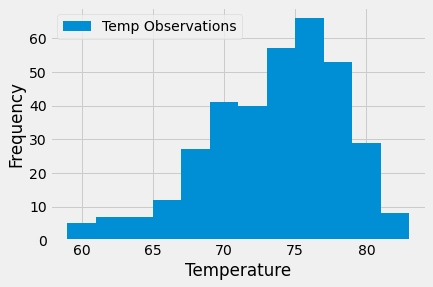

In [27]:
#Plot histogram
temp_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.legend(['Temp Observations'])

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
